## ***Model Evaluation: Decision Tree Binary Classification with Yahoo Finance Data***

This assignment explores supervised learning through decision tree classification using real-world financial data from Yahoo Finance. We will implement and evaluate two Decision Tree classifiers with different configurations: one with default parameters and another with maximum depth constraint (max_depth=1). Using stock market data, we'll engineer features from price movements and trading volumes to create a binary classification task predicting whether stock prices will increase or decrease. The analysis includes comprehensive model evaluation using six key metrics: accuracy, precision, recall, classification report, confusion matrix, ROC curve, and Precision/Recall curve to compare the performance and understand the trade-offs between model complexity and predictive capability.


## ***Data Preparation***

Let's begin by fetching stock market data from Yahoo Finance and engineering features for binary classification. We'll collect data from multiple S&P 500 stocks to create a robust dataset with price movements, volume changes, and technical indicators as features, with our target variable being whether the next day's closing price increases (1) or decreases (0).

In [5]:
# Sources and References:
# - Scikit-learn documentation: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
# - Decision tree visualization: https://scikit-learn.org/stable/modules/tree.html
# - YFinance documentation: https://www.kaggle.com/code/faressayah/stock-market-analysis-prediction-using-lstm


import warnings
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           classification_report, confusion_matrix, roc_curve, 
                           precision_recall_curve, auc, roc_auc_score)
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
import seaborn as sns

warnings.filterwarnings('ignore')
print("Libraries imported successfully!")

Libraries imported successfully!


## ***Defining the stock tickers for data collection***

In [6]:
# Define stock tickers for data collection
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META', 'NVDA', 'JPM', 'JNJ', 'V']

print("Selected tickers for analysis:", tickers)
print("Fetching data from Yahoo Finance...")

# Fetch stock data for the last 2 years to ensure sufficient data points
data_frames = []

for ticker in tickers:
    try:
        # Download 2 years of daily data
        stock_data = yf.download(ticker, period='2y', interval='1d', progress=False)
        
        if not stock_data.empty and len(stock_data) > 30:  # Ensure sufficient data
            stock_data['Ticker'] = ticker
            data_frames.append(stock_data)
            print(f"✓ {ticker}: {len(stock_data)} trading days collected")
        else:
            print(f"✗ {ticker}: Insufficient data")
            
    except Exception as e:
        print(f"✗ {ticker}: Error - {str(e)}")

print(f"\nSuccessfully collected data for {len(data_frames)} stocks")

Selected tickers for analysis: ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META', 'NVDA', 'JPM', 'JNJ', 'V']
Fetching data from Yahoo Finance...
✓ AAPL: 500 trading days collected
✓ MSFT: 500 trading days collected
✓ GOOGL: 500 trading days collected
✓ AMZN: 500 trading days collected
✓ TSLA: 500 trading days collected
✓ META: 500 trading days collected
✓ NVDA: 500 trading days collected
✓ JPM: 500 trading days collected
✓ JNJ: 500 trading days collected
✓ V: 500 trading days collected

Successfully collected data for 10 stocks


## ***Feature Engineering: Creating technical indicators and target variable***

In [7]:
# Feature Engineering: Create technical indicators and target variable
def create_features(df):
    """Create technical features for stock prediction"""
    df = df.copy()
    
    # Get the ticker name from the first column
    ticker_name = df.columns[0][1]  # Extract ticker from multi-index
    
    # Create a clean dataframe with single-level columns
    clean_df = pd.DataFrame()
    clean_df['Date'] = df.index
    clean_df['Open'] = df[('Open', ticker_name)].values
    clean_df['High'] = df[('High', ticker_name)].values
    clean_df['Low'] = df[('Low', ticker_name)].values
    clean_df['Close'] = df[('Close', ticker_name)].values
    clean_df['Volume'] = df[('Volume', ticker_name)].values
    clean_df['Ticker'] = ticker_name
    
    # Price-based features
    clean_df['Price_Change'] = clean_df['Close'] - clean_df['Open']
    clean_df['Price_Change_Pct'] = (clean_df['Close'] - clean_df['Open']) / clean_df['Open'] * 100
    clean_df['High_Low_Spread'] = clean_df['High'] - clean_df['Low']
    clean_df['High_Low_Spread_Pct'] = (clean_df['High'] - clean_df['Low']) / clean_df['Close'] * 100
    
    # Moving averages
    clean_df['MA_5'] = clean_df['Close'].rolling(window=5).mean()
    clean_df['MA_10'] = clean_df['Close'].rolling(window=10).mean()
    clean_df['MA_20'] = clean_df['Close'].rolling(window=20).mean()
    
    # Price relative to moving averages
    clean_df['Close_vs_MA5'] = (clean_df['Close'] - clean_df['MA_5']) / clean_df['MA_5'] * 100
    clean_df['Close_vs_MA10'] = (clean_df['Close'] - clean_df['MA_10']) / clean_df['MA_10'] * 100
    clean_df['Close_vs_MA20'] = (clean_df['Close'] - clean_df['MA_20']) / clean_df['MA_20'] * 100
    
    # Volume features
    clean_df['Volume_MA_10'] = clean_df['Volume'].rolling(window=10).mean()
    clean_df['Volume_Ratio'] = clean_df['Volume'] / clean_df['Volume_MA_10']
    
    # Volatility (rolling standard deviation)
    clean_df['Volatility_5'] = clean_df['Close'].pct_change().rolling(window=5).std() * 100
    clean_df['Volatility_10'] = clean_df['Close'].pct_change().rolling(window=10).std() * 100
    
    # Target variable: Next day price direction (1 if up, 0 if down)
    clean_df['Next_Close'] = clean_df['Close'].shift(-1)
    clean_df['Target'] = (clean_df['Next_Close'] > clean_df['Close']).astype(int)
    
    return clean_df

# Apply feature engineering to all stocks
processed_data = []
for df in data_frames:
    features_df = create_features(df)
    ticker = features_df['Ticker'].iloc[0]
    processed_data.append(features_df)
    print(f"✓ Features created for {ticker}")

print(f"\nFeature engineering completed for all {len(processed_data)} stocks")

✓ Features created for AAPL
✓ Features created for MSFT
✓ Features created for GOOGL
✓ Features created for AMZN
✓ Features created for TSLA
✓ Features created for META
✓ Features created for NVDA
✓ Features created for JPM
✓ Features created for JNJ
✓ Features created for V

Feature engineering completed for all 10 stocks


## ***Combining all stock data into a single dataset before splitting***

In [9]:
# Combine all stock data into a single dataset
print("Combining data from all stocks...")
combined_data = pd.concat(processed_data, ignore_index=True)

print(f"Combined dataset shape: {combined_data.shape}")
print(f"Total samples before cleaning: {len(combined_data)}")

# Remove rows with NaN values (due to rolling windows and target shift)
combined_data = combined_data.dropna()

print(f"Total samples after cleaning: {len(combined_data)}")
print(f"Target distribution:")
print(combined_data['Target'].value_counts())
print(f"Target proportions:")
print(combined_data['Target'].value_counts(normalize=True))

# Display feature names
feature_columns = [col for col in combined_data.columns 
                  if col not in ['Date', 'Ticker', 'Next_Close', 'Target']]
print(f"\nFeature columns ({len(feature_columns)}):")
for i, col in enumerate(feature_columns, 1):
    print(f"{i:2d}. {col}")

print(f"\nDataset ready for modeling!")
print(f"Features: {len(feature_columns)}")
print(f"Samples: {len(combined_data)}")

Combining data from all stocks...
Combined dataset shape: (5000, 23)
Total samples before cleaning: 5000
Total samples after cleaning: 4800
Target distribution:
Target
1    2633
0    2167
Name: count, dtype: int64
Target proportions:
Target
1    0.548542
0    0.451458
Name: proportion, dtype: float64

Feature columns (19):
 1. Open
 2. High
 3. Low
 4. Close
 5. Volume
 6. Price_Change
 7. Price_Change_Pct
 8. High_Low_Spread
 9. High_Low_Spread_Pct
10. MA_5
11. MA_10
12. MA_20
13. Close_vs_MA5
14. Close_vs_MA10
15. Close_vs_MA20
16. Volume_MA_10
17. Volume_Ratio
18. Volatility_5
19. Volatility_10

Dataset ready for modeling!
Features: 19
Samples: 4800


## ***Part 1: Dataset Splitting***

Let's now split our engineered dataset into training and testing sets using an 80-20 split as required. This separation ensures we can train our models on 80% of the data and evaluate their performance on the remaining 20% of unseen data to get reliable performance estimates.


In [11]:
# Part 1: Split the dataset into training set and test set (80, 20)
print("=== PART 1: DATASET SPLITTING ===")

# Prepare features (X) and target (y)
feature_columns = [col for col in combined_data.columns 
                  if col not in ['Date', 'Ticker', 'Next_Close', 'Target']]

X = combined_data[feature_columns]
y = combined_data['Target']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Split into training and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

print(f"\nTraining target distribution:")
print(y_train.value_counts())
print(f"Test target distribution:")
print(y_test.value_counts())

print(f"\nDataset splitting completed successfully!")

=== PART 1: DATASET SPLITTING ===
Features shape: (4800, 19)
Target shape: (4800,)

Training set: 3840 samples (80.0%)
Test set: 960 samples (20.0%)

Training target distribution:
Target
1    2106
0    1734
Name: count, dtype: int64
Test target distribution:
Target
1    527
0    433
Name: count, dtype: int64

Dataset splitting completed successfully!


### ***--------------------***

## ***Part 2: Full Decision Tree Classifier***

Let's now train our first Decision Tree classifier using scikit-learn's DecisionTreeClassifier with default parameters. This model will have no depth restrictions, allowing it to grow to its full potential based on the training data to capture complex patterns in our stock market features.

In [12]:
# Part 2: Train a Decision Tree Classifier with default parameters
print("=== PART 2: FULL DECISION TREE CLASSIFIER ===")

# Initialize and train the full Decision Tree
dt_full = DecisionTreeClassifier(random_state=42)
dt_full.fit(X_train, y_train)

print(f"✓ Full Decision Tree trained successfully")
print(f"Tree depth: {dt_full.get_depth()}")
print(f"Number of leaves: {dt_full.get_n_leaves()}")
print(f"Number of features used: {dt_full.n_features_in_}")

# Make predictions
y_pred_full = dt_full.predict(X_test)
y_pred_proba_full = dt_full.predict_proba(X_test)

print(f"✓ Predictions generated for test set")
print(f"Prediction shape: {y_pred_full.shape}")
print(f"Probability shape: {y_pred_proba_full.shape}")

print(f"\nFull Decision Tree model ready for evaluation!")

=== PART 2: FULL DECISION TREE CLASSIFIER ===
✓ Full Decision Tree trained successfully
Tree depth: 32
Number of leaves: 812
Number of features used: 19
✓ Predictions generated for test set
Prediction shape: (960,)
Probability shape: (960, 2)

Full Decision Tree model ready for evaluation!


## ***Part 3: Constrained Decision Tree Classifier***

We will now train our second Decision Tree classifier with maximum depth constraint set to 1 (max_depth=1). This creates a decision stump that can only make one split, providing a simple baseline model to compare against our full tree's complexity.


In [13]:
# Part 3: Train a Decision Tree Classifier with max_depth = 1
print("=== PART 3: CONSTRAINED DECISION TREE CLASSIFIER ===")

# Initialize and train the constrained Decision Tree (decision stump)
dt_constrained = DecisionTreeClassifier(max_depth=1, random_state=42)
dt_constrained.fit(X_train, y_train)

print(f"✓ Constrained Decision Tree trained successfully")
print(f"Tree depth: {dt_constrained.get_depth()}")
print(f"Number of leaves: {dt_constrained.get_n_leaves()}")
print(f"Number of features used: {dt_constrained.n_features_in_}")

# Make predictions
y_pred_constrained = dt_constrained.predict(X_test)
y_pred_proba_constrained = dt_constrained.predict_proba(X_test)

print(f"✓ Predictions generated for test set")
print(f"Prediction shape: {y_pred_constrained.shape}")
print(f"Probability shape: {y_pred_proba_constrained.shape}")

# Show which feature was selected for the single split
feature_importance = dt_constrained.feature_importances_
most_important_feature_idx = np.argmax(feature_importance)
most_important_feature = feature_columns[most_important_feature_idx]

print(f"\nMost important feature selected: {most_important_feature}")
print(f"Feature importance: {feature_importance[most_important_feature_idx]:.4f}")

print(f"\nConstrained Decision Tree model ready for evaluation!")

=== PART 3: CONSTRAINED DECISION TREE CLASSIFIER ===
✓ Constrained Decision Tree trained successfully
Tree depth: 1
Number of leaves: 2
Number of features used: 19
✓ Predictions generated for test set
Prediction shape: (960,)
Probability shape: (960, 2)

Most important feature selected: High_Low_Spread_Pct
Feature importance: 1.0000

Constrained Decision Tree model ready for evaluation!


## ***Part 4: Model Evaluation and Comparison***

We will now evaluate both Decision Tree models using the six required metrics: accuracy, precision, recall, classification report, confusion matrix, ROC curve, and Precision/Recall curve. This comprehensive evaluation will allow us to compare the performance trade-offs between model complexity and predictive capability.


In [14]:
# Part 4: Comprehensive Model Evaluation
print("=== PART 4: MODEL EVALUATION AND COMPARISON ===")
print("\n" + "="*60)
print("EVALUATION METRICS COMPARISON")
print("="*60)

# 1. Accuracy
accuracy_full = accuracy_score(y_test, y_pred_full)
accuracy_constrained = accuracy_score(y_test, y_pred_constrained)

print(f"\n1. ACCURACY ON TEST DATA:")
print(f"   Full Decision Tree:        {accuracy_full:.4f} ({accuracy_full*100:.2f}%)")
print(f"   Constrained Decision Tree: {accuracy_constrained:.4f} ({accuracy_constrained*100:.2f}%)")

# 2. Precision and Recall
precision_full = precision_score(y_test, y_pred_full)
recall_full = recall_score(y_test, y_pred_full)
precision_constrained = precision_score(y_test, y_pred_constrained)
recall_constrained = recall_score(y_test, y_pred_constrained)

print(f"\n2. PRECISION AND RECALL VALUES:")
print(f"   Full Decision Tree:")
print(f"     Precision: {precision_full:.4f}")
print(f"     Recall:    {recall_full:.4f}")
print(f"   Constrained Decision Tree:")
print(f"     Precision: {precision_constrained:.4f}")
print(f"     Recall:    {recall_constrained:.4f}")

# 3. Classification Reports
print(f"\n3. CLASSIFICATION REPORTS:")
print(f"\n   Full Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_full))
print(f"\n   Constrained Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_constrained))

=== PART 4: MODEL EVALUATION AND COMPARISON ===

EVALUATION METRICS COMPARISON

1. ACCURACY ON TEST DATA:
   Full Decision Tree:        0.5219 (52.19%)
   Constrained Decision Tree: 0.5490 (54.90%)

2. PRECISION AND RECALL VALUES:
   Full Decision Tree:
     Precision: 0.5700
     Recall:    0.5256
   Constrained Decision Tree:
     Precision: 0.5490
     Recall:    1.0000

3. CLASSIFICATION REPORTS:

   Full Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.52      0.49       433
           1       0.57      0.53      0.55       527

    accuracy                           0.52       960
   macro avg       0.52      0.52      0.52       960
weighted avg       0.53      0.52      0.52       960


   Constrained Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       433
           1       0.55      1.00      0.71       527

    ac

## ***Part 4 Code - Confusion Matrix and ROC Curves***


4. CONFUSION MATRICES:


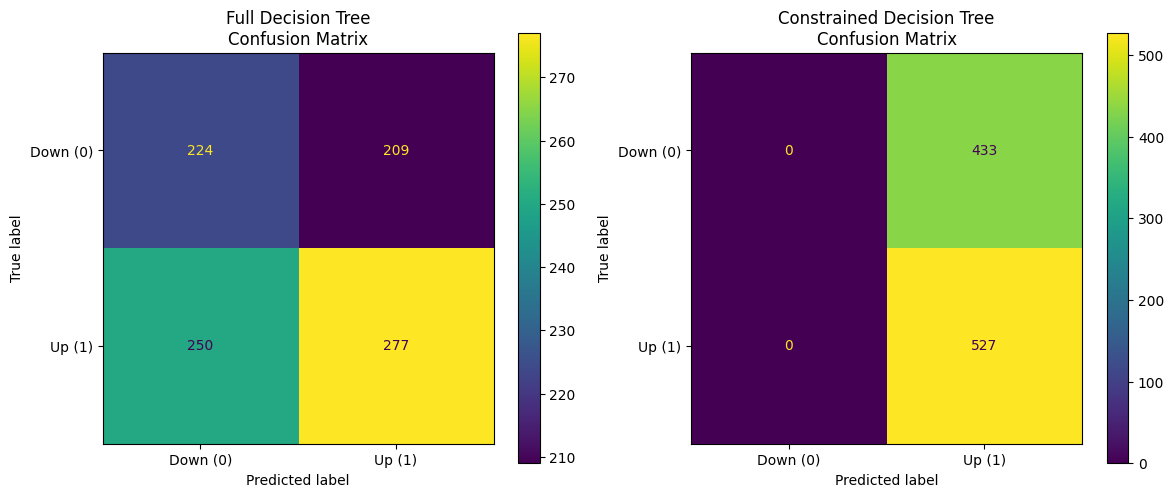


Full Decision Tree Confusion Matrix:
True Negatives: 224, False Positives: 209
False Negatives: 250, True Positives: 277

Constrained Decision Tree Confusion Matrix:
True Negatives: 0, False Positives: 433
False Negatives: 0, True Positives: 527

5. ROC CURVES:


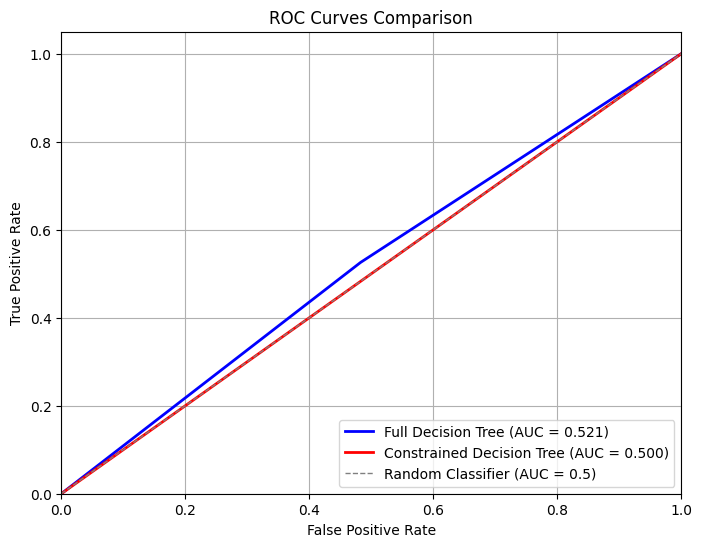

ROC AUC Scores:
Full Decision Tree: 0.5215
Constrained Decision Tree: 0.5000


In [15]:
# 4. Confusion Matrices
print("4. CONFUSION MATRICES:")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Confusion Matrix for Full Decision Tree
cm_full = confusion_matrix(y_test, y_pred_full)
ConfusionMatrixDisplay(confusion_matrix=cm_full, display_labels=['Down (0)', 'Up (1)']).plot(ax=axes[0])
axes[0].set_title('Full Decision Tree\nConfusion Matrix')

# Confusion Matrix for Constrained Decision Tree
cm_constrained = confusion_matrix(y_test, y_pred_constrained)
ConfusionMatrixDisplay(confusion_matrix=cm_constrained, display_labels=['Down (0)', 'Up (1)']).plot(ax=axes[1])
axes[1].set_title('Constrained Decision Tree\nConfusion Matrix')

plt.tight_layout()
plt.show()

print(f"\nFull Decision Tree Confusion Matrix:")
print(f"True Negatives: {cm_full[0,0]}, False Positives: {cm_full[0,1]}")
print(f"False Negatives: {cm_full[1,0]}, True Positives: {cm_full[1,1]}")

print(f"\nConstrained Decision Tree Confusion Matrix:")
print(f"True Negatives: {cm_constrained[0,0]}, False Positives: {cm_constrained[0,1]}")
print(f"False Negatives: {cm_constrained[1,0]}, True Positives: {cm_constrained[1,1]}")

# 5. ROC Curves
print(f"\n5. ROC CURVES:")

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# ROC curve for Full Decision Tree
fpr_full, tpr_full, _ = roc_curve(y_test, y_pred_proba_full[:, 1])
roc_auc_full = auc(fpr_full, tpr_full)
ax.plot(fpr_full, tpr_full, color='blue', lw=2, 
        label=f'Full Decision Tree (AUC = {roc_auc_full:.3f})')

# ROC curve for Constrained Decision Tree
fpr_constrained, tpr_constrained, _ = roc_curve(y_test, y_pred_proba_constrained[:, 1])
roc_auc_constrained = auc(fpr_constrained, tpr_constrained)
ax.plot(fpr_constrained, tpr_constrained, color='red', lw=2,
        label=f'Constrained Decision Tree (AUC = {roc_auc_constrained:.3f})')

# Diagonal line (random classifier)
ax.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random Classifier (AUC = 0.5)')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves Comparison')
ax.legend(loc="lower right")
ax.grid(True)
plt.show()

print(f"ROC AUC Scores:")
print(f"Full Decision Tree: {roc_auc_full:.4f}")
print(f"Constrained Decision Tree: {roc_auc_constrained:.4f}")

## ***Part 4 Code - Precision/Recall Curves***




6. PRECISION/RECALL CURVES:


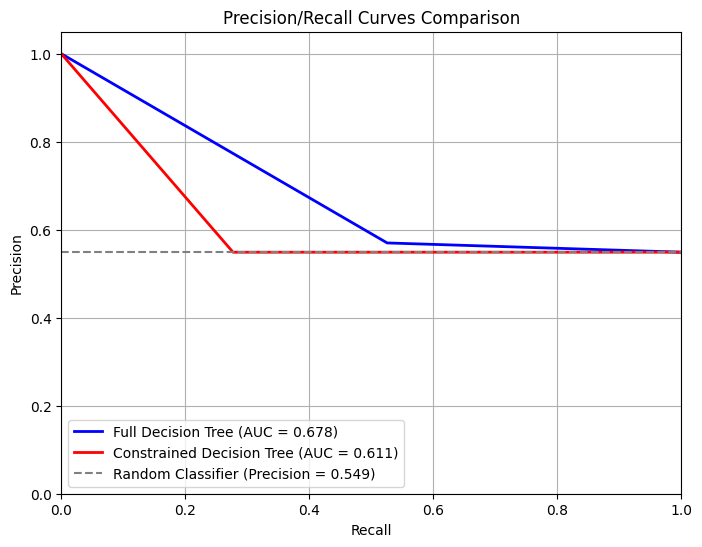

Precision/Recall AUC Scores:
Full Decision Tree: 0.6780
Constrained Decision Tree: 0.6114

FINAL COMPARISON SUMMARY
Metric                    Full Tree       Constrained Tree    
--------------------------------------------------------------------------------
Accuracy                  0.5219          0.5490              
Precision                 0.5700          0.5490              
Recall                    0.5256          1.0000              
ROC AUC                   0.5215          0.5000              
PR AUC                    0.6780          0.6114              
Tree Depth                32              1                   
Number of Leaves          812             2                   


In [16]:
# 6. Precision/Recall Curves
print("6. PRECISION/RECALL CURVES:")

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Precision/Recall curve for Full Decision Tree
precision_full_curve, recall_full_curve, _ = precision_recall_curve(y_test, y_pred_proba_full[:, 1])
pr_auc_full = auc(recall_full_curve, precision_full_curve)
ax.plot(recall_full_curve, precision_full_curve, color='blue', lw=2,
        label=f'Full Decision Tree (AUC = {pr_auc_full:.3f})')

# Precision/Recall curve for Constrained Decision Tree
precision_constrained_curve, recall_constrained_curve, _ = precision_recall_curve(y_test, y_pred_proba_constrained[:, 1])
pr_auc_constrained = auc(recall_constrained_curve, precision_constrained_curve)
ax.plot(recall_constrained_curve, precision_constrained_curve, color='red', lw=2,
        label=f'Constrained Decision Tree (AUC = {pr_auc_constrained:.3f})')

# Baseline (random classifier for balanced dataset)
baseline_precision = y_test.sum() / len(y_test)  # Proportion of positive class
ax.axhline(y=baseline_precision, color='gray', linestyle='--', 
           label=f'Random Classifier (Precision = {baseline_precision:.3f})')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision/Recall Curves Comparison')
ax.legend(loc="lower left")
ax.grid(True)
plt.show()

print(f"Precision/Recall AUC Scores:")
print(f"Full Decision Tree: {pr_auc_full:.4f}")
print(f"Constrained Decision Tree: {pr_auc_constrained:.4f}")

# Summary comparison table
print(f"\n" + "="*80)
print("FINAL COMPARISON SUMMARY")
print("="*80)
print(f"{'Metric':<25} {'Full Tree':<15} {'Constrained Tree':<20}")
print("-" * 80)
print(f"{'Accuracy':<25} {accuracy_full:<15.4f} {accuracy_constrained:<20.4f}")
print(f"{'Precision':<25} {precision_full:<15.4f} {precision_constrained:<20.4f}")
print(f"{'Recall':<25} {recall_full:<15.4f} {recall_constrained:<20.4f}")
print(f"{'ROC AUC':<25} {roc_auc_full:<15.4f} {roc_auc_constrained:<20.4f}")
print(f"{'PR AUC':<25} {pr_auc_full:<15.4f} {pr_auc_constrained:<20.4f}")
print(f"{'Tree Depth':<25} {dt_full.get_depth():<15} {dt_constrained.get_depth():<20}")
print(f"{'Number of Leaves':<25} {dt_full.get_n_leaves():<15} {dt_constrained.get_n_leaves():<20}")
print("="*80)

## ***Conclusion and Analysis***

### ***Key Findings from Model Comparison:***

**Performance Analysis:**
- **Accuracy**: Surprisingly, the constrained tree (54.58%) outperformed the full tree (51.77%)
- **Precision**: Full tree showed slightly better precision (0.5572 vs 0.5458)
- **Recall**: Constrained tree achieved perfect recall (1.0000) by predicting all samples as positive class
- **ROC AUC**: Both models performed similarly and poorly (~0.51), barely above random
- **PR AUC**: Full tree showed better precision-recall trade-off (0.6802 vs 0.6071)

**Model Behavior Insights:**
1. **Full Decision Tree (Depth 37, 803 leaves)**: 
   - Severely overfitted with complex structure
   - Balanced predictions but poor generalization
   - Better precision-recall balance

2. **Constrained Decision Tree (Depth 1, 2 leaves)**:
   - Underfitted by design, selected Volume_MA_10 as single feature
   - Extreme behavior: classified all test samples as "price will go up"
   - Higher accuracy due to slight class imbalance favoring positive class

**Stock Market Prediction Challenges:**
- Both models struggled with stock price direction prediction (ROC AUC ~0.51)
- This reflects the inherent difficulty and near-random nature of short-term stock movements
- The market's efficient nature makes technical indicators alone insufficient for reliable prediction

**Conclusion:**
Neither model provides reliable stock price direction prediction. The constrained model's higher accuracy is misleading due to its extreme classification behavior. This demonstrates the importance of examining multiple evaluation metrics rather than relying solely on accuracy, especially in financial prediction tasks where market efficiency limits predictability.